In [1]:
import math
import random
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

# GDR

## User-side data encoding and perturbation for GDR

In [2]:
class User:
    def __init__(self, age, p=0, q=0):
        self.v = age
        self.D = [i for i in range(1,101)]
        self.d = 100
        self.p = p
        self.q = q
        
    def toss_a_coin(self): # to your witcher, oh valley of plenty
        probabilities = [self.p, 1 - self.p]
        
        # 0 heads, 1 tails
        return random.choices([0,1], weights = probabilities, k = 1)[0]
    
    def report(self):
        result = self.toss_a_coin()
        
        if result == 0:
            return self.v
        else:
            d_minus = list(filter(lambda x: x != self.v, self.D))
            return random.choice(d_minus)

## Results without using GDR to see the comparison

In [3]:
class Raw:
    def __init__(self):
        self.users = self.get_users()
        self.ages = [user.v for user in self.users]
        self.dist = Counter(self.ages)
        
    def get_users(self):
        users = []

        with open("ages.txt") as age_file:
            for age in age_file:
                users.append(User(int(age.replace('\n',''))))
                
        return users
    
    def plot_hist(self):
        plt.figure(figsize=(20, 3))
        plt.xlabel("Ages", labelpad=16, fontsize=16)
        plt.ylabel("Number of people", labelpad=16, fontsize=16)
        plt.bar(self.dist.keys(), self.dist.values())
        plt.show()

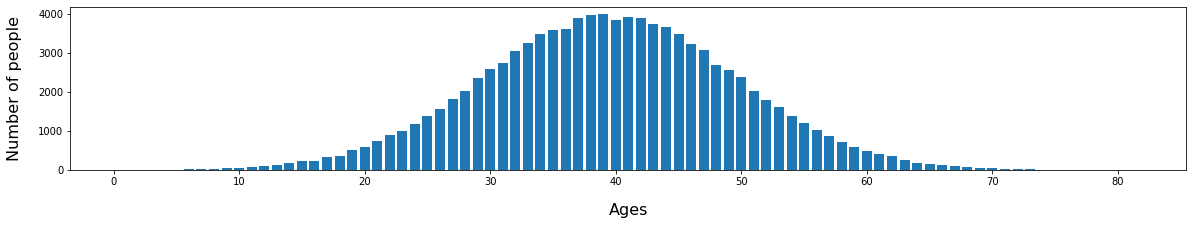

In [4]:
raw = Raw()
raw.plot_hist()

## Server-side estimation for GRR

In [5]:
# (b)
class GDR:
    def __init__(self, epsilon=8):
        self.d = 100
        self.epsilon = epsilon
        self.p = math.exp(epsilon) / (math.exp(epsilon) + self.d - 1)
        self.q = (1 - self.p) / (self.d - 1)
        self.users = self.get_users()
        self.aggregation = self.aggregate() # keys are ages, values are ivs
        self.estimations = self.get_estimates()
        
    def get_users(self):
        users = []

        with open("ages.txt") as age_file:
            for age in age_file:
                users.append(User(int(age.replace('\n','')), self.p, self.q))
                
        return users
        
    def get_reported_values(self):
        ages = [user.report() for user in self.users]
        return ages
    
    def aggregate(self):
        counter = Counter(self.get_reported_values())
        
        return counter
        
    def estimate(self, age):
        I_v = self.aggregation[age]
        estimation = (I_v - len(self.users) * self.q) / (self.p - self.q)
        # print(f'Age: {age}, IV: {I_v}, n: {len(self.users)}, p: {self.p}, q: {self.q}, Estimation: {estimation}')
        #print((I_v - len(self.users) * self.q))
        
        return estimation
    
    def get_estimates(self):
        estimations = {}
        
        for age in self.aggregation.keys():
            estimation = self.estimate(age)
            estimations[age] = estimation
            
        return estimations
    
    def plot_hist(self):
        plt.figure(figsize=(20, 3))
        plt.xlabel("Ages", labelpad=16, fontsize=16)
        plt.ylabel("Number of people", labelpad=16, fontsize=16)
        plt.bar(self.estimations.keys(), self.estimations.values())
        plt.show()

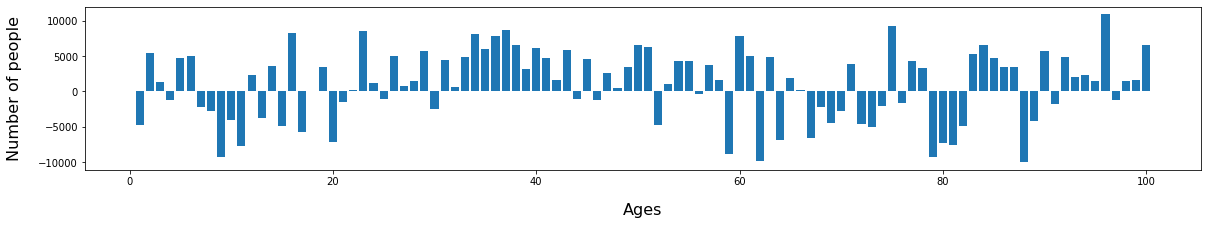

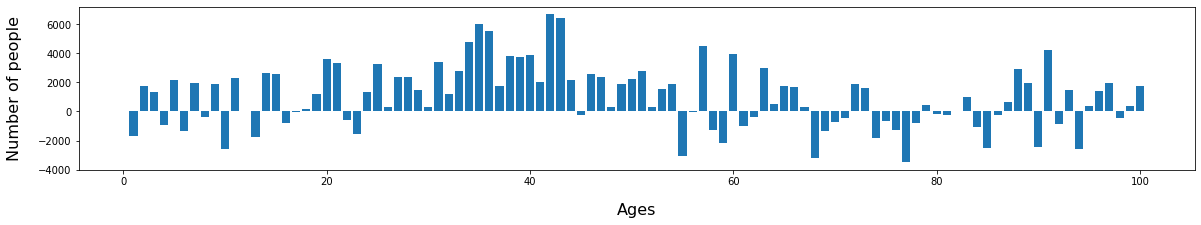

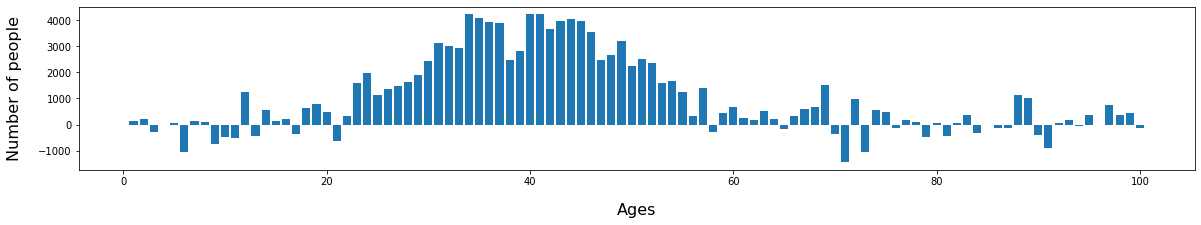

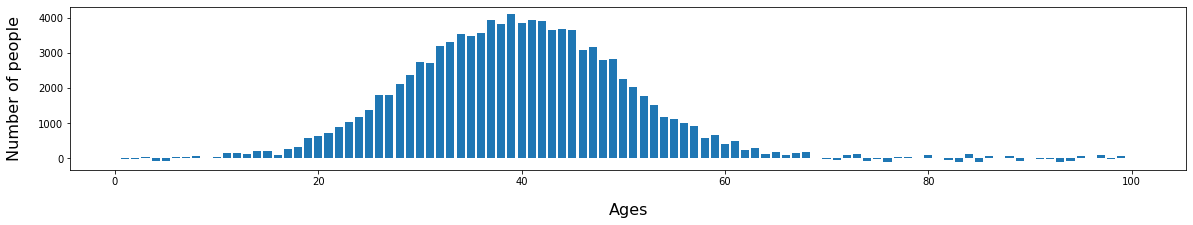

In [6]:
epsilons = [0.5, 1.0, 2.0, 4.0]
for epsilon in epsilons:
    gdr = GDR(epsilon)
    gdr.plot_hist()

## Error metric for different epsilon values

In [7]:
# (c)
epsilons = [0.5, 1.0, 2.0, 4.0]

for epsilon in epsilons:
    diff = 0
    gdr = GDR(epsilon)
    raw = Raw()
    gdr_results = gdr.estimations
    raw_results = raw.dist
    
    for key in range(1,100):
        try:
            diff += abs(gdr_results[key] - raw_results[key]) 
        except:
            continue
    
    diff /= 100
            
    print(f'Diff when epsilon {epsilon}: {diff}')        

Diff when epsilon 0.5: 3552.3759312568773
Diff when epsilon 1.0: 1378.9974707810925
Diff when epsilon 2.0: 386.8929282489971
Diff when epsilon 4.0: 61.58305825312586


# Simple RAPPOR

## User-side data encoding and perturbation for Simple RAPPOR

In [22]:
class User:
    def __init__(self, age, p=0, q=0):
        self.v = age
        self.d = 100
        self.p = p
        self.q = q
        self.x = self.get_bit_vector()
        self.perturbed = self.perturb_bit_vector()
    
    def get_bit_vector(self):
        bit_vector = [0] * 100
        bit_vector[self.v] = 1
        return bit_vector
    
    def toss_a_coin(self): # to your witcher, oh valley of plenty
        probabilities = [self.p, self.q]
        
        # 0 preserve, 1 flip
        return random.choices([0,1], weights = probabilities, k = 1)[0]    
        
    def perturb_bit_vector(self):
        perturbed = []
        
        for index,digit in enumerate(self.x):
            result = self.toss_a_coin()
            
            if result == 1:
                perturbed.append(1 - digit)
            else:
                perturbed.append(digit)
        
        return perturbed

## Server-side estimation for Simple RAPPOR

In [23]:
class SimpleRAPPOR:
    def __init__(self, epsilon=1):
        self.p = math.exp(epsilon/2) / (math.exp(epsilon / 2) + 1)
        self.q = 1 / (math.exp(epsilon / 2) + 1)
        self.users = self.get_users()
        self.aggregation = self.aggregate()
        self.estimations = self.get_estimates()
    
    def get_users(self):
        users = []

        with open("ages.txt") as age_file:
            for age in age_file:
                users.append(User(int(age.replace('\n','')), self.p, self.q))
                
        return users
    
    def aggregate(self):
        aggregation = [0] * 100
        
        for user in self.users:
            for index,digit in enumerate(user.perturbed):
                aggregation[index] += digit
                
        return aggregation
    
    def estimate(self, age):
        I_v = self.aggregation[age]
        estimation = (I_v - len(self.users) * self.q) / (self.p - self.q)
        
        return estimation
        
    def get_estimates(self):
        estimates = {}
        for age in range(len(self.aggregation)):
            estimation = self.estimate(age)
            estimates[age] = estimation
            
        return estimates
    
    def plot_hist(self):
        plt.figure(figsize=(20, 3))
        plt.xlabel("Ages", labelpad=16, fontsize=16)
        plt.ylabel("Number of people", labelpad=16, fontsize=16)
        plt.bar(self.estimations.keys(), self.estimations.values())
        plt.show()

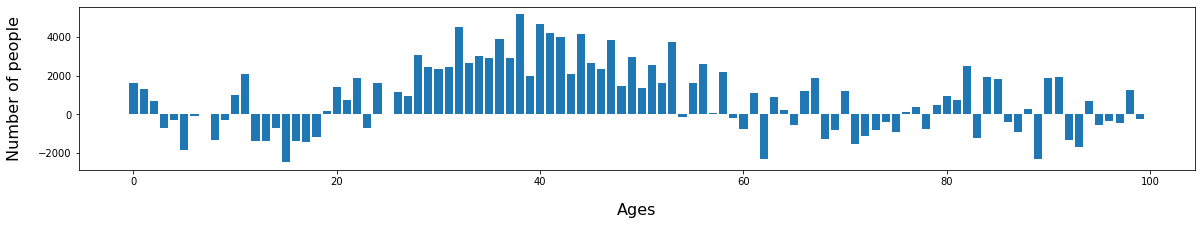

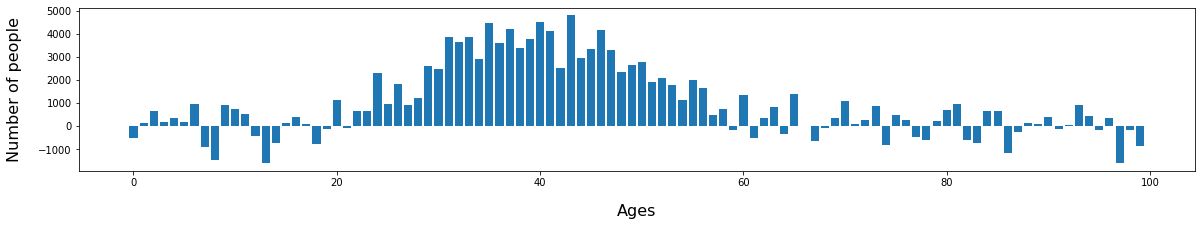

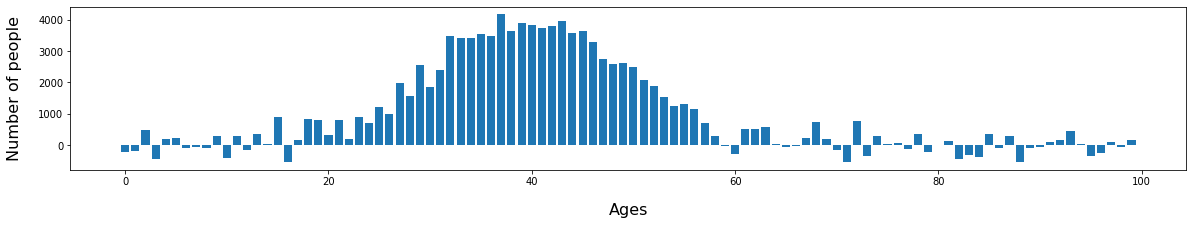

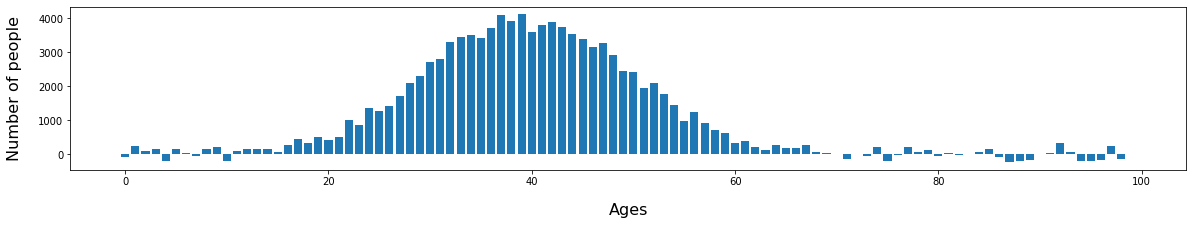

In [25]:
epsilons = [0.5, 1.0, 2.0, 4.0]
for epsilon in epsilons:
    rappor = SimpleRAPPOR(epsilon)
    rappor.plot_hist()

In [26]:
epsilons = [0.5, 1.0, 2.0, 4.0]

for epsilon in epsilons:
    diff = 0
    rappor = SimpleRAPPOR(epsilon)
    raw = Raw()
    rappor_results = rappor.estimations
    raw_results = raw.dist
    
    for key in range(1,100):
        try:
            diff += abs(rappor_results[key] - raw_results[key]) 
        except:
            continue
    
    diff /= 100
            
    print(f'Diff when epsilon {epsilon}: {diff}')        

Diff when epsilon 0.5: 1050.3074548652073
Diff when epsilon 1.0: 552.8131618512793
Diff when epsilon 2.0: 235.6007034022305
Diff when epsilon 4.0: 102.53449093656711
